<a href="https://colab.research.google.com/github/dingowhiz/Data_Analytics_ML/blob/main/autoencoder_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Anomaly Detection using Autoencoder**
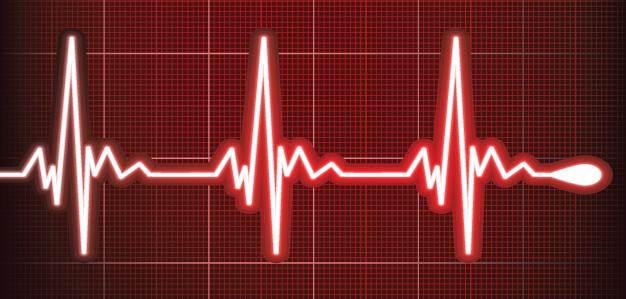

This presentation uses autoencoders to perform anomaly detection in systems.

An autoencoder is a neural network that is trained to copy its input to its output. For example, given a telemetry, human activity or machine operational and performance data, an autoencoder is able to encode the state of a setting or machine into a lower dimensional latent representation, then decodes the latent representation back to the normal state. An autoencoder learns to compress the data while minimizing the reconstruction error. 

In this notebook, I will train an autoencoder to detect anomalies on ECG dataset. Normal ECG will be denoted by 1 and abnormal rhythm 0.

The process involves training of an autoencoder on the normal ECG only and then use it to reconstruct the data. The goal is to identify and classify abnormal ECG at a fixed threshold and has a higher reconstruction error than normal ECG.

## Data Flow
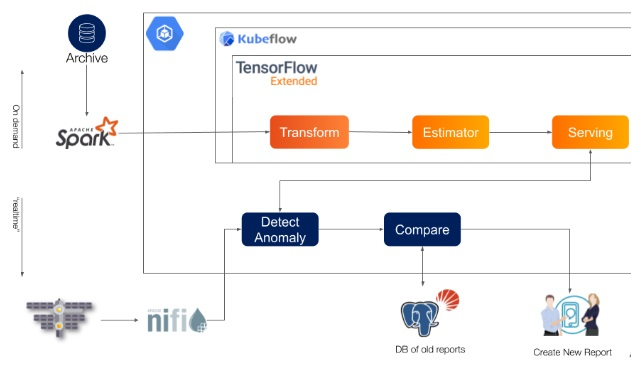


## How to use Autoencoder to detect system anomaly?
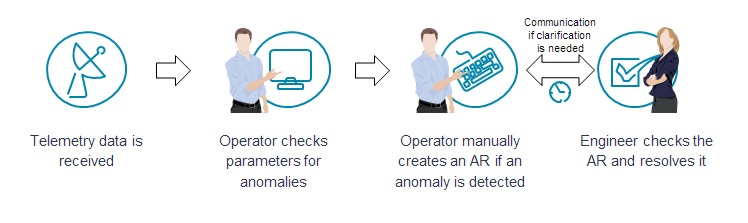

## Autoencoder Design
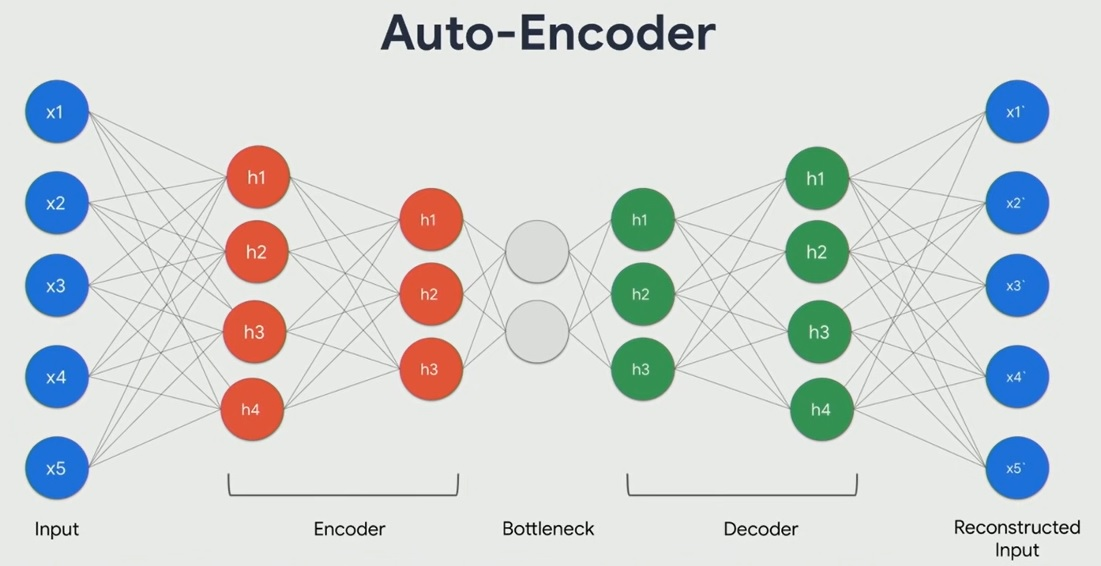

## Autoencoder Architecture
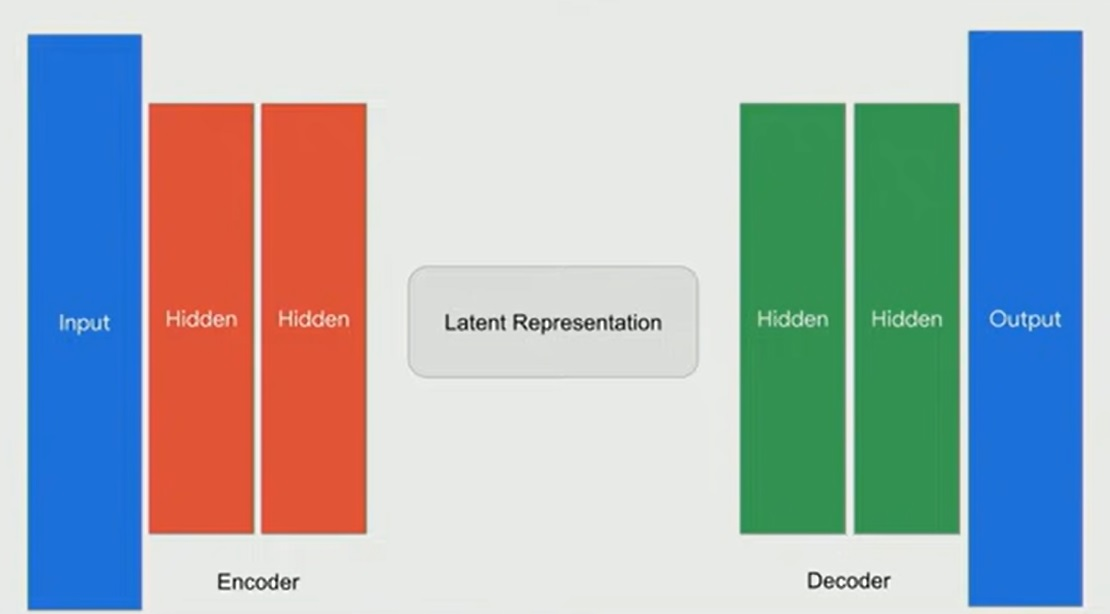

## Anomaly Detection in ECG
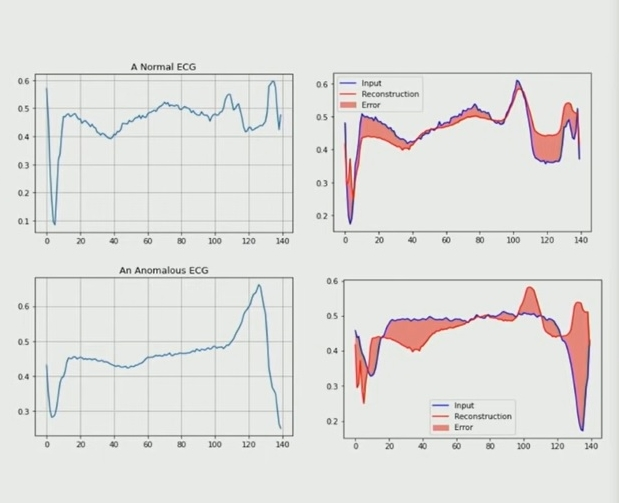

# Implementation using Tensorflow and Python

---



## Import TensorFlow and other libraries

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

### Load ECG data

In [24]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [25]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

Normalize the data to `[0,1]`.


In [26]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

Train the autoencoder by using only the normal ECG rhythms, which are labeled in the dataset as `1`. Separate the normal rhythms from the abnormal rhythms.

In [27]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

Plot a normal and anomalous ECG. 

Text(0, 0.5, 'mv')

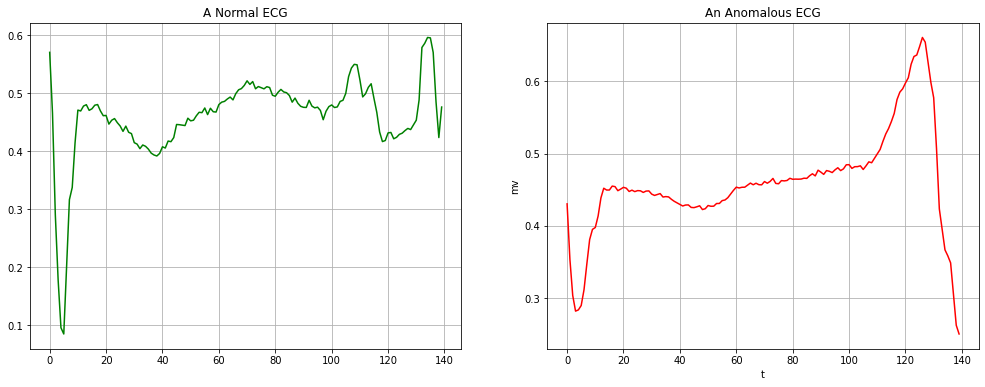

In [70]:

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(17, 6))
ax1.grid()
ax1.set_title('A Normal ECG')
ax1.plot(np.arange(140), normal_train_data[0], 'g')
plt.xlabel('t')
plt.ylabel('mv')
ax2.grid()
ax2.set_title("An Anomalous ECG")
ax2.plot(np.arange(140), anomalous_train_data[0], 'r')
plt.xlabel('t')
plt.ylabel('mv')

### Build the model

In [71]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [72]:
autoencoder.compile(optimizer='adam', loss='mae')

In [73]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=20, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
5/5 [==============================] - 1s 51ms/step - loss: 0.0581 - val_loss: 0.0526
Epoch 2/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0552 - val_loss: 0.0508
Epoch 3/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0522 - val_loss: 0.0494
Epoch 4/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0490 - val_loss: 0.0481
Epoch 5/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0455 - val_loss: 0.0460
Epoch 6/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0421 - val_loss: 0.0444
Epoch 7/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0389 - val_loss: 0.0430
Epoch 8/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0362 - val_loss: 0.0415
Epoch 9/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0339 - val_loss: 0.0407
Epoch 10/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0318 - val_loss: 0.0393
Epoch 11/20
5/5 [====================

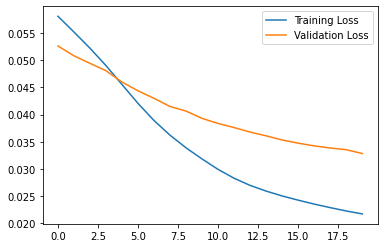

In [74]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

An ECG is classified as anomalous if the reconstruction error is greater than one standard deviation from the normal training examples. 

plot a normal ECG from the training set, the reconstruction after it's encoded and decoded by the autoencoder, and the reconstruction error.

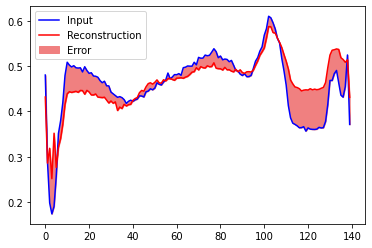

In [75]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Create a similar plot for an anomalous test sample.

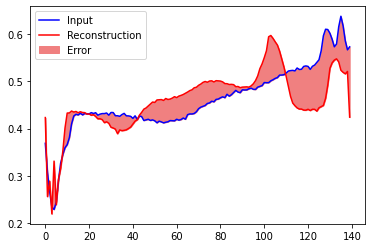

In [76]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### Detect anomalies



1.   Detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold. 
2.   Calculate the mean average error for normal examples from the training set.
3. classify sample as anomalous if the reconstruction error is higher than one standard deviation from the training set.


Plot the reconstruction error on normal ECGs from the training set

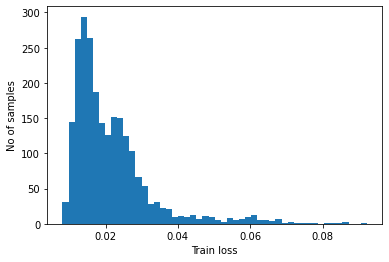

In [83]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of samples")
plt.show()

Choose a threshold value that is one standard deviations above the mean.

In [78]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.03264524


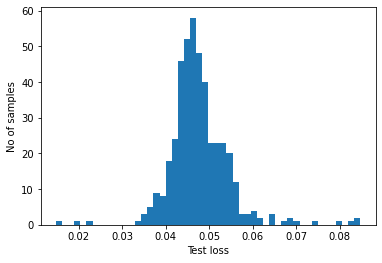

In [82]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of samples")
plt.show()

Classify an ECG as an anomaly if the reconstruction error is greater than the threshold.

In [80]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Specificity = {}".format(recall_score(labels, predictions,pos_label=0)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [81]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.943
Precision = 0.9941060903732809
Specificity = 0.9931818181818182
Recall = 0.9035714285714286


## Conclusion

The result shows the high precision and sensitivity of over 90% and specificity of 99%. Autoencoder which is based on neural networks is a pretty good algorithm to predict anomalies in ECG data. 

It works by calculating the loss in the reconstruction of the ECG waveform and plot the loss distribution and compare it with a normal ECG distribution. With good training datasets and by using a threshold value of the loss function, an accurate classification of abnormal ECG ready can be achieved. 

For complex problems like transport operations, microscopic or satelite imaging with high data dimensionality, CNN based neural networks will be better suited and can be deployed to achieve high accuracy of the prediction.